## ANALISIS DE ENERGÍA DIARIA A PARTIR DE LOS DATOS DE SOLCAST Y FRONIUS 

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/var/folders/pz/w3bcsy5x2wgb_7c0fs6qmkp80000gn/T/ipykernel_52996/2499521001.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Lectura DB inversor Fronius 

In [2]:
#  Cargar los datos del archivo CSV
df_SFV = pd.read_csv('../Data/Cleaned/SFV_2023.csv', sep=',')


## Lectura DB Solcast 

In [3]:
# Cargar los datos del archivo CSV
df_solcast = pd.read_csv('../Data/Cleaned/solcast_2023.csv', sep=',')
print(df_solcast.shape)



(105408, 12)


## Método para filtrar datos de un solo día 

In [14]:
# filtrar un dia de datos 
Fecha = '2023-05-08'
row_day_solcast = df_solcast.loc[df_solcast['Date'] == Fecha]
row_day_fronius = df_SFV.loc[df_SFV['Date'] == Fecha]
print(row_day_solcast.shape)
print(row_day_fronius.shape)

(288, 12)
(288, 26)


In [15]:
# reiniciar el index
row_day_solcast = row_day_solcast.reset_index(drop=True)
row_day_fronius = row_day_fronius.reset_index(drop=True)

In [16]:
# Odenernar row_day_solcast de menor a mayor hora
row_day_solcast = row_day_solcast.sort_values(by='Time')
row_day_solcast = row_day_solcast.reset_index(drop=True)

In [17]:
# Crear un nuevo dataframe con los datos de solcast y fronius a partir del indice 
df = pd.DataFrame()
df['Time'] = row_day_solcast['Time']
df['GHI'] = row_day_solcast['GHI']
df['air_temp'] = row_day_solcast['air_temp']
df['cloud_opacity'] = row_day_solcast['cloud_opacity']
df['Producción_fotovoltaica_SFV'] = row_day_fronius['Producción_fotovoltaica_SFV']


## Análisis producción de energía 


In [22]:
# alpha y beta 
alpha = 0.22213855462049642
beta = 0


#Parametros SFV
efficiency = 0.2094  # Eficiencia del panel solar
catidad_pv= 30
area =2.274*1.134

# normalizar 'cloud_opacity' de 0 a 1  en donde 1 es el valor más alto
df['cloud_opacity'] = df['cloud_opacity'] / df['cloud_opacity'].max()
# normalizar 'air_temp' de 0 a 1  en donde 1 es el valor más alto
df['air_temp'] = df['air_temp'] / df['air_temp'].max()


# Energía calculada a partir de Solcast 
df['P_cloud_opacity_temp'] = df['GHI'] * efficiency *  area * catidad_pv * (1 - beta*df['cloud_opacity']) * (1 - alpha*df['air_temp'])


# suma de la potencia generada solcast
energia = df['P_cloud_opacity_temp']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)



# Energía calculada a partir de Fronius
df['Potencia'] = df['Producción_fotovoltaica_SFV'] / (5/60)
energia_fronius = df['Producción_fotovoltaica_SFV'].sum()
print("Producción fotovoltaica SVF [kWh/día] =",energia_fronius/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# Horas de brillo solar
hbs = energia_fronius / (30*0.54)
print("Horas de brillo solar =", hbs/1000)

Energía calculada solacast [kWh] = 80.60007035003885
Producción fotovoltaica SVF [kWh/día] = 80.60007
Error porcentual: 4.3429098899534105e-07 %
Horas de brillo solar = 4.975312962962963


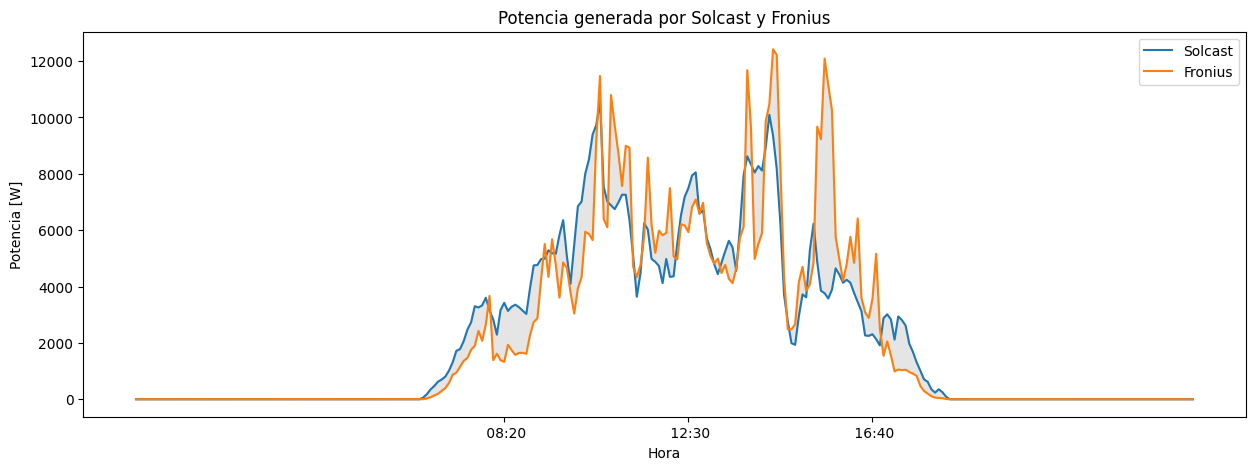

In [11]:
# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P_cloud_opacity_temp'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P_cloud_opacity_temp'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks([100, 150, 200])
plt.show()

## Análisis de las DB

/opt/homebrew/lib/python3.11/site-packages/seaborn/axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


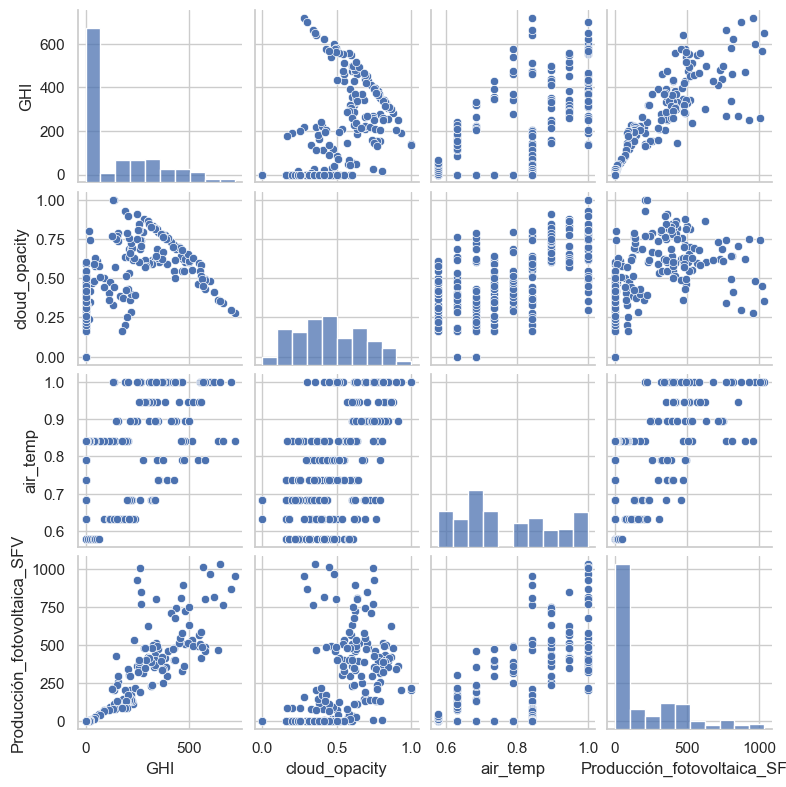

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set
sns.set(style="whitegrid", context="notebook")
cols = ['GHI', 'cloud_opacity', 'air_temp', 'Producción_fotovoltaica_SFV']
sns.pairplot(df[cols], size=2)
plt.show()


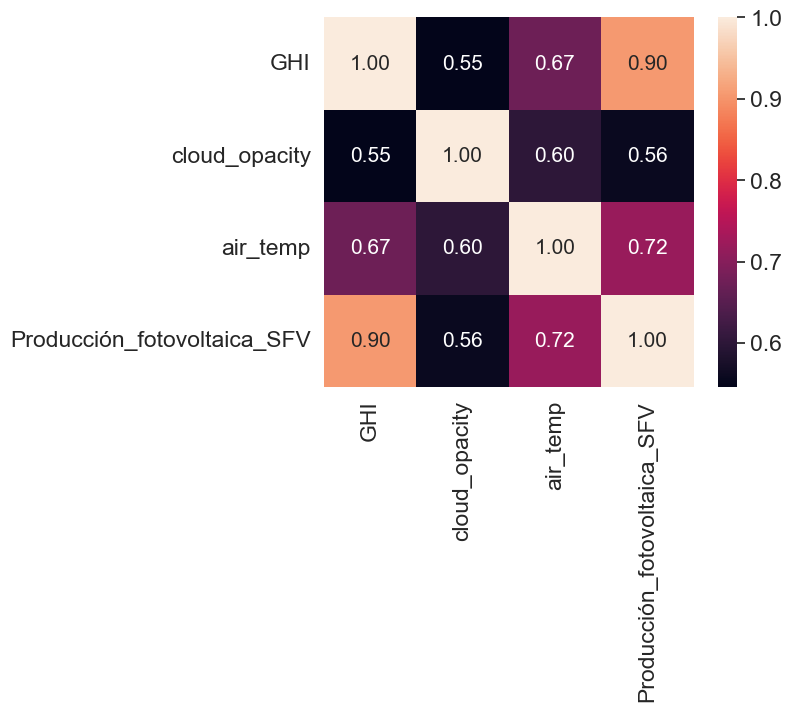

In [13]:
#heatmap
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

In [ ]:
# modelo de regresión lineal con scikit-learn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df[['air_temp', 'cloud_opacity']].values
y = df['Producción_fotovoltaica_SFV'].values.reshape(-1, 1)
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y)

slr = LinearRegression()
slr.fit(X_std, y_std)




In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import *
import numpy as np

x1_range = np.arange(df['cloud_opacity'].min(), df['cloud_opacity'].max())
x2_range = np.arange(df['air_temp'].min(), df['air_temp'].max())
x1, x2 = np.meshgrid(x1_range, x2_range)
plano = pd.DataFrame({'cloud_opacity': x1.ravel(), 'air_temp': x2.ravel()})
pred = slr.predict(sc_x.transform(plano)).reshape(x1.shape)
pred = sc_y.inverse_transform(pred)

fig = plt.figure()
ax = fig.add_subplot( projection='3d')
ax.plot_surface(x1, x2, pred, rstride=1, cstride=1, alpha=0.2, color='blue')
ax.scatter(df['cloud_opacity'], df['air_temp'], df['Producción_fotovoltaica_SFV'], c='red')
plt.show()

## Análisis por error

In [ ]:
from scipy.optimize import minimize

# Define la función de error (en este caso, el error cuadrático medio)
def error_func(params):
    alpha, beta = params
    #Parametros SFV
    efficiency = 0.2094  # Eficiencia del panel solar
    catidad_pv= 30
    area =2.274*1.134
    predicted_power = df['GHI'] * efficiency * area * catidad_pv * (1 - beta * df['cloud_opacity']) * (1 - alpha * df['air_temp'])
    error = ((predicted_power - df['Potencia']) ** 2).mean()  # Error cuadrático medio
    return error

# Suponiendo que tengas valores iniciales para alpha y beta
initial_guess = [0.1, 0.1]  # Por ejemplo

# Realiza la optimización para minimizar el error
result = minimize(error_func, initial_guess, method='Nelder-Mead')

# Los valores óptimos se encuentran en result.x
optimal_alpha, optimal_beta = result.x
print("Los valores óptimos son:")
print("Alpha:", optimal_alpha)
print("Beta:", optimal_beta)


## 🏐

In [19]:
from scipy.optimize import minimize

# Función para minimizar la diferencia entre las energías calculadas
def objective_function(params):
    alpha, beta = params
    energia_solcast = df['GHI'] * efficiency * area * catidad_pv * (1 - beta * df['cloud_opacity']) * (1 - alpha * df['air_temp']) * (5 / 60)
    diff = energia_solcast.sum() - energia_fronius
    return abs(diff)

# Valores iniciales de alpha y beta
initial_guess = [0.1, 0.1]

# Minimización de la función objetivo
result = minimize(objective_function, initial_guess, bounds=((0, 1), (-1, 0)))
alpha_optimal, beta_optimal = result.x

print("Alpha óptimo:", alpha_optimal)
print("Beta óptimo:", beta_optimal)


Alpha óptimo: 0.22213855462049642
Beta óptimo: 0.0
